In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize, LinearSegmentedColormap
import matplotlib.colors as mcolors 
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import MinMaxScaler
import decoupler as dc
import scipy
from scipy.stats import ranksums, kruskal, sem, mannwhitneyu
from scipy.stats import wilcoxon
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

# Ensure the base matplotlib module is imported
import matplotlib  # Add this line to import the main module

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Path to font
helvetica_neue_path = Path.home() / ".local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object
prop_neue = fm.FontProperties(fname=helvetica_neue_path)
helvetica_neue_name = prop_neue.get_name()

# Custom font/graphing for Seaborn
custom_context = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 7,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.6,
    'lines.linewidth': 0.6,
    'lines.markersize': 3,
    'patch.linewidth': 0.6,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.title_fontsize': 7,
}

# Additional custom aesthetics for Seaborn
custom_style = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#EAEAEA',
    'grid.linestyle': '--',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',
        'font.sans-serif': [helvetica_neue_name],
        'font.size': 7,
        'axes.labelsize': 7,
        'axes.titlesize': 7,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set root and output directory
REPO_ROOT = Path.cwd().resolve()
output_dir = REPO_ROOT / "figure7_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Turn on CPLEX in terminal
# Compass input is a cell x gene matrix normalized to CPM in .tsv file
# In terminal > execute compass by running the following code
    # compass --data '/path/to/tsv/input-file.tsv' --output-dir '/path/to/desired/output' --model RECON2_mat --species homo_sapiens --penalty-diffusion knn --lambda 0 --num-neighbors 30 --microcluster-size 25

In [5]:
# Check for file availability
required_files = [
    "rxn_md.csv",
    "compass_reactions_nhc_cd4_naive.tsv",
    "compass_reactions_nhc_cd4_effem.tsv",
    "compass_reactions_nhc_cd4_treg.tsv",
    "compass_reactions_ci-sep_cd4_naive.tsv",
    "compass_reactions_ci-sep_cd4_effem.tsv",
    "compass_reactions_ci-sep_cd4_treg.tsv",
]

missing_files = [f for f in required_files if not (REPO_ROOT / f).exists()]

if missing_files:
    missing_str = "\n".join(missing_files)
    raise FileNotFoundError(
        f"The following required files are missing from the Figure7 directory:\n\n"
        f"{missing_str}\n\n"
        "These files are required to reproduce Figure 7:\n"
        "  - Precomputed Compass reaction outputs (`compass_reactions_*.tsv`)\n"
        "  - RECON2 reaction metadata (`rxn_md.csv`)\n\n"
        "If not recalculated as above, they are available in the GitHub repository:\n"
        "https://github.com/StierLab/2025-CD4T-sepsis\n\n"
        "Download the files and place them in the Figure7 directory before running "
        "this notebook."
    )

In [6]:
# Load compass reaction files > reactions.tsv from compass > renamed as below and moved to root directory
def import_and_prepare(filepath, cell_type, treatment_group):
    df = pd.read_csv(filepath, sep="\t", index_col=0)
    
    # Convert reaction penalties to consistencies
    df = -np.log(df + 1)

    # Rename columns to include cell type and treatment group at the end
    df.columns = [f"{col}_{treatment_group}_{cell_type}" for col in df.columns]
   
    return df

data_frames = [
    import_and_prepare("compass_reactions_nhc_cd4_naive.tsv", "CD4_T_Naive", "NHC"),
    import_and_prepare("compass_reactions_nhc_cd4_effem.tsv", "CD4_T_EffEM", "NHC"),
    import_and_prepare("compass_reactions_nhc_cd4_treg.tsv", "CD4_Treg", "NHC"),
    import_and_prepare("compass_reactions_ci-sep_cd4_naive.tsv", "CD4_T_Naive", "CI-Sep"),
    import_and_prepare("compass_reactions_ci-sep_cd4_effem.tsv", "CD4_T_EffEM", "CI-Sep"),
    import_and_prepare("compass_reactions_ci-sep_cd4_treg.tsv", "CD4_Treg", "CI-Sep"),
]

# Merge into a single file
merged_df = pd.concat(data_frames, axis=1)
merged_df.reset_index(inplace=True)
merged_df.rename(columns={"index": "Reaction"}, inplace=True)

merged_df

,Reaction,cluster_0_NHC_CD4_T_Naive,cluster_1_NHC_CD4_T_Naive,cluster_2_NHC_CD4_T_Naive,cluster_3_NHC_CD4_T_Naive,cluster_4_NHC_CD4_T_Naive,cluster_5_NHC_CD4_T_Naive,cluster_6_NHC_CD4_T_Naive,cluster_7_NHC_CD4_T_Naive,cluster_8_NHC_CD4_T_Naive,...,cluster_138_CI-Sep_CD4_Treg,cluster_139_CI-Sep_CD4_Treg,cluster_140_CI-Sep_CD4_Treg,cluster_141_CI-Sep_CD4_Treg,cluster_142_CI-Sep_CD4_Treg,cluster_143_CI-Sep_CD4_Treg,cluster_144_CI-Sep_CD4_Treg,cluster_145_CI-Sep_CD4_Treg,cluster_146_CI-Sep_CD4_Treg,cluster_147_CI-Sep_CD4_Treg
0,10FTHF5GLUtl_pos,-8.193329,-8.163647,-8.163667,-8.169323,-8.143393,-8.104093,-8.141189,-8.157648,-8.166930,...,-8.208869,-8.322299,-8.294339,-8.282694,-8.118193,-8.165328,-8.156579,-8.154800,-8.158537,-8.155693
1,10FTHF5GLUtm_pos,-8.514041,-8.503149,-8.520010,-8.510913,-8.513707,-8.618349,-8.514735,-8.500496,-8.501861,...,-8.525703,-8.525543,-8.529378,-8.515406,-8.467334,-8.518672,-8.503839,-8.504532,-8.504288,-8.502561
2,10FTHF6GLUtl_pos,-8.359293,-8.319259,-8.319143,-8.327194,-8.290693,-8.236920,-8.287461,-8.310821,-8.323550,...,-8.380669,-8.495086,-8.486066,-8.459858,-8.256824,-8.321823,-8.310200,-8.307330,-8.312533,-8.308994
3,10FTHF6GLUtm_pos,-8.557526,-8.544561,-8.561383,-8.553689,-8.554955,-8.629053,-8.559197,-8.537371,-8.540530,...,-8.574680,-8.574942,-8.578589,-8.560161,-8.485870,-8.564556,-8.544313,-8.545739,-8.543705,-8.542366
4,10FTHF7GLUtl_pos,-8.442783,-8.410992,-8.410805,-8.420101,-8.378072,-8.316583,-8.374297,-8.401283,-8.415808,...,-8.453980,-8.574025,-8.562426,-8.536957,-8.338426,-8.414015,-8.400895,-8.397456,-8.403424,-8.399522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10206,sink_pre_prot(r)_pos,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
10207,sink_tetdec2coa(c)_neg,-9.836320,-9.682312,-9.711007,-9.674657,-9.530416,-9.729023,-9.645133,-9.712860,-9.683858,...,-9.867814,-9.800039,-9.780373,-9.642594,-9.669059,-9.706198,-9.564431,-9.621512,-9.584296,-9.639114
10208,sink_tetdec2coa(c)_pos,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
10209,sink_tetdece1coa(c)_neg,-9.836320,-9.682312,-9.711007,-9.674657,-9.530416,-9.729023,-9.645133,-9.712860,-9.683858,...,-9.867814,-9.800039,-9.780373,-9.642594,-9.669059,-9.706198,-9.564431,-9.621512,-9.584296,-9.639114


In [7]:
# Filter out all reactions in the negative direction and remove remaining directional specifiers
merged_df_filtered = merged_df[~merged_df.iloc[:, 0].str.endswith('_neg')].copy()
merged_df_filtered['Reaction'] = merged_df_filtered.iloc[:, 0].str.replace('(_pos)$', '', regex=True)

# Remove reactions with no variability across the dataset
def get_reaction_consistencies(df, min_range=1e-3):
    
    # Calculate and filter based on variability
    numeric_columns = df.select_dtypes(include="number").columns
    is_variable = (df[numeric_columns].max(axis=1) - df[numeric_columns].min(axis=1)) >= min_range
    df_filtered = df.loc[is_variable].copy()
    
    # Normalize numeric columns
    numeric_columns = df_filtered.select_dtypes(include='number').columns
    global_min = df_filtered[numeric_columns].to_numpy().min()
    df_filtered.loc[:, numeric_columns] = df_filtered[numeric_columns] - global_min

    return df_filtered

merged_df_filtered = get_reaction_consistencies(merged_df_filtered)

# Ensure only numeric columns are considered for the calculations
numeric_columns = merged_df_filtered.select_dtypes(include='number').columns

# Calculate the mean for each reaction (row-wise) using only numeric columns
reaction_means = merged_df_filtered[numeric_columns].mean(axis=1)

# Calculate the standard deviation for each reaction (row-wise) using only numeric columns
reaction_std_devs = merged_df_filtered[numeric_columns].std(axis=1)

# Adding calculated means and standard deviations as new columns
merged_df_filtered['Mean'] = reaction_means
merged_df_filtered['StdDev'] = reaction_std_devs
merged_df_filtered

,Reaction,cluster_0_NHC_CD4_T_Naive,cluster_1_NHC_CD4_T_Naive,cluster_2_NHC_CD4_T_Naive,cluster_3_NHC_CD4_T_Naive,cluster_4_NHC_CD4_T_Naive,cluster_5_NHC_CD4_T_Naive,cluster_6_NHC_CD4_T_Naive,cluster_7_NHC_CD4_T_Naive,cluster_8_NHC_CD4_T_Naive,...,cluster_140_CI-Sep_CD4_Treg,cluster_141_CI-Sep_CD4_Treg,cluster_142_CI-Sep_CD4_Treg,cluster_143_CI-Sep_CD4_Treg,cluster_144_CI-Sep_CD4_Treg,cluster_145_CI-Sep_CD4_Treg,cluster_146_CI-Sep_CD4_Treg,cluster_147_CI-Sep_CD4_Treg,Mean,StdDev
0,10FTHF5GLUtl,3.768422,3.798104,3.798084,3.792428,3.818358,3.857658,3.820562,3.804103,3.794821,...,3.667412,3.679057,3.843558,3.796423,3.805172,3.806952,3.803214,3.806058,3.789136,0.046066
1,10FTHF5GLUtm,3.447710,3.458602,3.441742,3.450838,3.448045,3.343403,3.447016,3.461255,3.459891,...,3.432373,3.446346,3.494417,3.443079,3.457912,3.457220,3.457463,3.459190,3.441033,0.059775
2,10FTHF6GLUtl,3.602458,3.642492,3.642608,3.634558,3.671058,3.724831,3.674291,3.650930,3.638201,...,3.475685,3.501893,3.704927,3.639929,3.651551,3.654421,3.649218,3.652757,3.631748,0.060800
3,10FTHF6GLUtm,3.404225,3.417190,3.400368,3.408062,3.406796,3.332698,3.402554,3.424380,3.421222,...,3.383163,3.401590,3.475881,3.397196,3.417439,3.416012,3.418046,3.419385,3.397347,0.066439
4,10FTHF7GLUtl,3.518968,3.550759,3.550946,3.541650,3.583680,3.645168,3.587455,3.560469,3.545943,...,3.399325,3.424794,3.623326,3.547736,3.560856,3.564295,3.558327,3.562229,3.542288,0.065362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10185,r2535,4.349729,5.420495,4.639648,4.713730,4.624396,4.724039,4.712687,4.788749,4.659213,...,5.934177,4.884414,5.964426,5.900267,4.855950,5.523949,4.831548,5.785809,4.934341,0.484932
10189,r2538,1.621119,1.746922,1.722992,1.740719,1.802250,1.702383,1.770783,1.746001,1.719543,...,1.550733,1.625238,1.727602,1.664597,1.830647,1.770698,1.769022,1.774316,1.724050,0.066347
10191,r2539,7.716577,7.718239,7.691470,7.719970,7.765294,7.697981,7.725780,7.713653,7.756850,...,7.711309,7.741803,7.748647,7.734495,7.776182,7.771836,7.782820,7.760114,7.727348,0.047110
10193,sink_5hpet(c),7.091722,7.229484,7.183388,7.255802,7.268483,7.137143,7.227550,7.298894,7.188158,...,7.092866,7.177923,7.209524,7.152668,7.322085,7.286019,7.258691,7.265831,7.219185,0.087178


In [8]:
# Load and filter RECON2 reaction metadata
def load_and_filter_reaction_metadata(filepath):
    
    # Load reaction metadata
    reaction_metadata = pd.read_csv(filepath)
    
    # Filter out reactions that don't have an EC number
    reaction_metadata_filtered = reaction_metadata[
        reaction_metadata["rxn_EC_number"].notna()
    ]
    
    # Further filter by reaction confidence levels (keep 0 and 4)
    reaction_metadata_filtered = reaction_metadata_filtered[
        reaction_metadata_filtered["rxn_confidence"].isin([0, 4])
    ]
    
    # Adjust subsystem classification for reactions not in the mitochondria; e.g. no [m] in formula and annotated as TCA cycle
    reaction_metadata_filtered.loc[
        (~reaction_metadata_filtered["rxn_formula"].str.contains(r"\[m\]", regex=True)) &
        (reaction_metadata_filtered["subsystem"] == "Citric acid cycle"),
        "subsystem"
    ] = "Other"
    
    return reaction_metadata_filtered

# Load and filter the reaction metadata
reaction_metadata_filtered = load_and_filter_reaction_metadata("rxn_md.csv")
reaction_metadata_filtered

,rxn_code_nodirection,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
40,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0
46,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
50,34DHPLACOX,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",Tyrosine metabolism,51,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0
51,34DHPLACOX_NADP_,"3,4-Dihydroxyphenylacetaldehyde:NADP+ oxidored...",Tyrosine metabolism,52,1.2.1.5,ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0
52,34DHXMANDACOX,"3,4-Dihydroxymandelaldehyde:NAD+ oxidoreductase",Tyrosine metabolism,53,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0
...,...,...,...,...,...,...,...,...
6796,HSD17B3r,testicular 17-beta-hydroxysteroid dehydrogenase,Steroid metabolism,6797,1.1.1.62,HSD17B3,1.00 * proton [r] + 1.00 * Nicotinamide adenin...,4.0
7358,GNDc,phosphogluconate dehydrogenase,Pentose phosphate pathway,7359,1.1.1.44,PGD,3.00 * Nicotinamide adenine dinucleotide phosp...,4.0
7377,P5CR,pyrroline-5-carboxylate reductase,Arginine and Proline Metabolism,7378,1.5.1.2,PYCR1; PYCR2; PYCRL,2.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
7379,PGLc,6-phosphogluconolactonase,Pentose phosphate pathway,7380,3.1.1.31,PGLS,3.00 * Water [c] + 3.00 * 6-phospho-D-glucono-...,4.0


In [9]:
# Merge reaction consistency data frame with reaction metadata

# If 'Reaction' is the index, reset it to make 'Reaction' a column
if 'Reaction' not in merged_df_filtered.columns:
    merged_df_filtered.reset_index(inplace=True)

# Rename metadata reaction ID column to match 'Reaction' for merging
reaction_metadata_filtered = reaction_metadata_filtered.rename(columns={'rxn_code_nodirection': 'Reaction'})

# Inner join to keep only reactions present in both data frames
combined_df_meta = pd.merge(merged_df_filtered, reaction_metadata_filtered, on='Reaction', how='inner')
combined_df_meta

,Reaction,cluster_0_NHC_CD4_T_Naive,cluster_1_NHC_CD4_T_Naive,cluster_2_NHC_CD4_T_Naive,cluster_3_NHC_CD4_T_Naive,cluster_4_NHC_CD4_T_Naive,cluster_5_NHC_CD4_T_Naive,cluster_6_NHC_CD4_T_Naive,cluster_7_NHC_CD4_T_Naive,cluster_8_NHC_CD4_T_Naive,...,cluster_147_CI-Sep_CD4_Treg,Mean,StdDev,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
0,2HBO,9.581170,9.510753,9.511608,9.510272,9.655986,9.497023,9.583777,9.595897,9.569277,...,9.663089,9.561675,0.057833,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0
1,34DHOXPEGOX,1.263973,1.351379,1.314454,1.321286,1.413807,1.280588,1.374036,1.357791,1.333082,...,1.389558,1.325949,0.056662,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
2,34DHPLACOX,4.269308,4.302489,4.292270,4.301403,4.301037,4.292647,4.298617,4.300079,4.276653,...,4.278302,4.287813,0.103172,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",Tyrosine metabolism,51,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0
3,34DHXMANDACOX,4.269308,4.302489,4.292270,4.301403,4.301037,4.292647,4.298617,4.300079,4.276653,...,4.278302,4.285646,0.084358,"3,4-Dihydroxymandelaldehyde:NAD+ oxidoreductase",Tyrosine metabolism,53,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0
4,34HPPOR,0.867071,1.003926,0.972896,0.981511,1.019498,0.950175,0.993469,0.982324,0.949674,...,1.019630,0.959102,0.061201,4-Hydroxyphenylpyruvate:oxygen oxidoreductase,Tyrosine metabolism,56,1.13.11.27,HPD,1.00 * O2 [c] + 1.00 * 3-(4-hydroxyphenyl)pyru...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,r1464,4.843663,4.006326,4.006326,4.006326,4.800877,4.006326,4.771692,4.844797,4.737235,...,4.822968,4.364575,0.388471,Active transport,"Transport, mitochondrial",4466,1.3.1.27,NaN,1.00 * pyruvate [m] + 1.00 * acetoacetate [c] ...,0.0
1510,r1467,0.876081,0.982238,0.964997,0.988489,1.062468,0.924372,1.012742,0.954320,0.987849,...,1.029102,0.956518,0.071745,Postulated transport reaction,"Transport, mitochondrial",4468,2.3.1.86,NaN,1.00 * Octadecenoyl-CoA (n-C18:1CoA) [c] --> 1...,0.0
1511,r1487,1.621119,1.746922,1.722992,1.740719,1.802250,1.702383,1.770783,1.746001,1.719543,...,1.774316,1.724050,0.066347,EC:6.2.1.3,Fatty acid oxidation,4475,6.2.1.3,ACSBG2; ACSL1; ACSL3; ACSL4; ACSL5; ACSL6; SLC...,1.00 * ATP [r] + 1.00 * Coenzyme A [r] + 1.00 ...,0.0
1512,r1488,1.766413,1.939881,1.933982,1.936387,2.040193,1.882497,2.010300,1.932959,1.904621,...,1.988060,1.930569,0.087920,EC:6.2.1.3,Fatty acid oxidation,4476,6.2.1.3,NaN,1.00 * ATP [c] + 1.00 * Coenzyme A [c] + 1.00 ...,0.0


In [10]:
# Ensure 'Reaction' is a column. If it's an index, convert it to a column first.
if 'Reaction' not in combined_df_meta.columns:
    combined_df_meta.reset_index(inplace=True)

# Initialize the aggregated DataFrame with 'Reaction' and metadata columns
metadata_columns = ['Reaction', 'rxn_name_long', 'subsystem', 'ind_in_original_recon',
                    'rxn_EC_number', 'genes_associated_with_rxn', 'rxn_formula', 'rxn_confidence']

aggregated_df = combined_df_meta[metadata_columns].copy()

# Extract common naming pattern from column names for the cluster data
cluster_suffix_regex = r"cluster_\d+_(.*)"

# Extract and store the unique suffixes for aggregation
unique_suffixes = combined_df_meta.columns.str.extract(cluster_suffix_regex, expand=False).dropna().unique()

# Aggregate data for each unique suffix
for suffix in unique_suffixes:
    matching_columns = combined_df_meta.columns[
        combined_df_meta.columns.str.contains(rf"_{re.escape(suffix)}$", regex=True)
    ]
    aggregated_df[suffix] = combined_df_meta[matching_columns].mean(axis=1)

# Carry forward 'Mean' and 'StdDev' from combined_df_meta to aggregated_df
aggregated_df['Mean'] = combined_df_meta['Mean']
aggregated_df['StdDev'] = combined_df_meta['StdDev']

aggregated_df

,Reaction,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence,NHC_CD4_T_Naive,NHC_CD4_T_EffEM,NHC_CD4_Treg,CI-Sep_CD4_T_Naive,CI-Sep_CD4_T_EffEM,CI-Sep_CD4_Treg,Mean,StdDev
0,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0,9.547605,9.547131,9.569858,9.585845,9.588343,9.604302,9.561675,0.057833
1,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0,1.312961,1.320257,1.316541,1.347394,1.349008,1.346623,1.325949,0.056662
2,34DHPLACOX,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",Tyrosine metabolism,51,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.290396,4.279941,4.269059,4.294830,4.286260,4.306169,4.287813,0.103172
3,34DHXMANDACOX,"3,4-Dihydroxymandelaldehyde:NAD+ oxidoreductase",Tyrosine metabolism,53,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.288074,4.279172,4.269059,4.292133,4.285302,4.291574,4.285646,0.084358
4,34HPPOR,4-Hydroxyphenylpyruvate:oxygen oxidoreductase,Tyrosine metabolism,56,1.13.11.27,HPD,1.00 * O2 [c] + 1.00 * 3-(4-hydroxyphenyl)pyru...,4.0,0.944778,0.953751,0.943397,0.981629,0.986302,0.978542,0.959102,0.061201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,r1464,Active transport,"Transport, mitochondrial",4466,1.3.1.27,NaN,1.00 * pyruvate [m] + 1.00 * acetoacetate [c] ...,0.0,4.280462,4.279691,4.501421,4.458348,4.528862,4.678901,4.364575,0.388471
1510,r1467,Postulated transport reaction,"Transport, mitochondrial",4468,2.3.1.86,NaN,1.00 * Octadecenoyl-CoA (n-C18:1CoA) [c] --> 1...,0.0,0.939278,0.946083,0.944004,0.984208,0.991616,0.984875,0.956518,0.071745
1511,r1487,EC:6.2.1.3,Fatty acid oxidation,4475,6.2.1.3,ACSBG2; ACSL1; ACSL3; ACSL4; ACSL5; ACSL6; SLC...,1.00 * ATP [r] + 1.00 * Coenzyme A [r] + 1.00 ...,0.0,1.711026,1.717962,1.709496,1.745384,1.750215,1.740060,1.724050,0.066347
1512,r1488,EC:6.2.1.3,Fatty acid oxidation,4476,6.2.1.3,NaN,1.00 * ATP [c] + 1.00 * Coenzyme A [c] + 1.00 ...,0.0,1.911382,1.922518,1.906247,1.959451,1.971241,1.951935,1.930569,0.087920


In [11]:
# Identify numeric data columns for z-score calculation
data_columns = aggregated_df.select_dtypes(include='number').columns.drop(['Mean', 'StdDev'])
# Exclude specific metadata columns by name if they are included in the numeric columns
exclude_columns = ['rxn_name_long', 'subsystem', 'ind_in_original_recon', 
                   'rxn_EC_number', 'genes_associated_with_rxn', 'rxn_formula', 'rxn_confidence']
data_columns = [col for col in data_columns if col not in exclude_columns]

# Ensure 'Mean' and 'StdDev' columns exist and have valid data
if 'Mean' in aggregated_df.columns and 'StdDev' in aggregated_df.columns and not aggregated_df['StdDev'].eq(0).any():
    for col in data_columns:
        # Calculate z-score for each data column
        z_score_column_name = f'z_{col}'
        aggregated_df[z_score_column_name] = (aggregated_df[col] - aggregated_df['Mean']) / aggregated_df['StdDev']
else:
    print("Missing 'Mean'/'StdDev' columns or division by zero detected.")

# Replace infinite z-scores with NaN
aggregated_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Verify structure
aggregated_df

,Reaction,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence,NHC_CD4_T_Naive,NHC_CD4_T_EffEM,...,CI-Sep_CD4_T_EffEM,CI-Sep_CD4_Treg,Mean,StdDev,z_NHC_CD4_T_Naive,z_NHC_CD4_T_EffEM,z_NHC_CD4_Treg,z_CI-Sep_CD4_T_Naive,z_CI-Sep_CD4_T_EffEM,z_CI-Sep_CD4_Treg
0,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0,9.547605,9.547131,...,9.588343,9.604302,9.561675,0.057833,-0.243273,-0.251475,0.141501,0.417935,0.461133,0.737081
1,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0,1.312961,1.320257,...,1.349008,1.346623,1.325949,0.056662,-0.229221,-0.100451,-0.166032,0.378468,0.406952,0.364868
2,34DHPLACOX,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",Tyrosine metabolism,51,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.290396,4.279941,...,4.286260,4.306169,4.287813,0.103172,0.025040,-0.076294,-0.181770,0.068018,-0.015055,0.177922
3,34DHXMANDACOX,"3,4-Dihydroxymandelaldehyde:NAD+ oxidoreductase",Tyrosine metabolism,53,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.288074,4.279172,...,4.285302,4.291574,4.285646,0.084358,0.028773,-0.076754,-0.196625,0.076900,-0.004076,0.070268
4,34HPPOR,4-Hydroxyphenylpyruvate:oxygen oxidoreductase,Tyrosine metabolism,56,1.13.11.27,HPD,1.00 * O2 [c] + 1.00 * 3-(4-hydroxyphenyl)pyru...,4.0,0.944778,0.953751,...,0.986302,0.978542,0.959102,0.061201,-0.234047,-0.087425,-0.256600,0.368091,0.444447,0.317646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,r1464,Active transport,"Transport, mitochondrial",4466,1.3.1.27,NaN,1.00 * pyruvate [m] + 1.00 * acetoacetate [c] ...,0.0,4.280462,4.279691,...,4.528862,4.678901,4.364575,0.388471,-0.216523,-0.218510,0.352266,0.241389,0.422906,0.809134
1510,r1467,Postulated transport reaction,"Transport, mitochondrial",4468,2.3.1.86,NaN,1.00 * Octadecenoyl-CoA (n-C18:1CoA) [c] --> 1...,0.0,0.939278,0.946083,...,0.991616,0.984875,0.956518,0.071745,-0.240292,-0.145448,-0.174415,0.385949,0.489216,0.395247
1511,r1487,EC:6.2.1.3,Fatty acid oxidation,4475,6.2.1.3,ACSBG2; ACSL1; ACSL3; ACSL4; ACSL5; ACSL6; SLC...,1.00 * ATP [r] + 1.00 * Coenzyme A [r] + 1.00 ...,0.0,1.711026,1.717962,...,1.750215,1.740060,1.724050,0.066347,-0.196305,-0.091761,-0.219367,0.321546,0.394362,0.241312
1512,r1488,EC:6.2.1.3,Fatty acid oxidation,4476,6.2.1.3,NaN,1.00 * ATP [c] + 1.00 * Coenzyme A [c] + 1.00 ...,0.0,1.911382,1.922518,...,1.971241,1.951935,1.930569,0.087920,-0.218240,-0.091573,-0.276636,0.328502,0.462600,0.243018


In [12]:
# Exclude specified subsystems directly
aggregated_df_filtered = aggregated_df[
    ~aggregated_df['subsystem'].isin(["Miscellaneous", "Unassigned"])
]

# Further exclude subsystems containing "Transport" or "Exchange", or labeled as "Other"
aggregated_df_filtered = aggregated_df_filtered[
    ~aggregated_df_filtered['subsystem'].apply(
        lambda x: "Transport" in x or "Exchange" in x or x == "Other"
    )
]

# Calculate counts for remaining subsystems
items, counts = np.unique(aggregated_df_filtered['subsystem'], return_counts=True)
items_with_enough_reactions = [items[i] for i in range(len(items)) if counts[i] > 3]

# Keep only subsystems with more than 3 reactions
aggregated_df_filtered = aggregated_df_filtered[
    aggregated_df_filtered['subsystem'].isin(items_with_enough_reactions)
]

aggregated_df_filtered

,Reaction,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence,NHC_CD4_T_Naive,NHC_CD4_T_EffEM,...,CI-Sep_CD4_T_EffEM,CI-Sep_CD4_Treg,Mean,StdDev,z_NHC_CD4_T_Naive,z_NHC_CD4_T_EffEM,z_NHC_CD4_Treg,z_CI-Sep_CD4_T_Naive,z_CI-Sep_CD4_T_EffEM,z_CI-Sep_CD4_Treg
0,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0,9.547605,9.547131,...,9.588343,9.604302,9.561675,0.057833,-0.243273,-0.251475,0.141501,0.417935,0.461133,0.737081
1,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0,1.312961,1.320257,...,1.349008,1.346623,1.325949,0.056662,-0.229221,-0.100451,-0.166032,0.378468,0.406952,0.364868
2,34DHPLACOX,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",Tyrosine metabolism,51,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.290396,4.279941,...,4.286260,4.306169,4.287813,0.103172,0.025040,-0.076294,-0.181770,0.068018,-0.015055,0.177922
3,34DHXMANDACOX,"3,4-Dihydroxymandelaldehyde:NAD+ oxidoreductase",Tyrosine metabolism,53,1.2.1.5,ALDH1A3; ALDH3A1; ALDH3B1,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,4.0,4.288074,4.279172,...,4.285302,4.291574,4.285646,0.084358,0.028773,-0.076754,-0.196625,0.076900,-0.004076,0.070268
4,34HPPOR,4-Hydroxyphenylpyruvate:oxygen oxidoreductase,Tyrosine metabolism,56,1.13.11.27,HPD,1.00 * O2 [c] + 1.00 * 3-(4-hydroxyphenyl)pyru...,4.0,0.944778,0.953751,...,0.986302,0.978542,0.959102,0.061201,-0.234047,-0.087425,-0.256600,0.368091,0.444447,0.317646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,r1449,EC:1.3.3.6,Fatty acid oxidation,4457,1.3.3.6,ACOX1; ACOX3,1.00 * ubiquinone-10 [m] + 1.00 * Tetradecanoy...,0.0,3.140631,3.148209,...,3.199908,3.219082,3.161746,0.107917,-0.195661,-0.125443,-0.038038,0.291736,0.353622,0.531295
1506,r1450,EC:1.3.3.6,Fatty acid oxidation,4458,1.3.3.6,ACOX1; ACOX3,1.00 * ubiquinone-10 [m] + 1.00 * Hexanoyl-CoA...,0.0,3.141053,3.148643,...,3.200432,3.219643,3.162203,0.108011,-0.195814,-0.125544,-0.037892,0.291853,0.353934,0.531791
1507,r1451,EC:1.3.3.6,Fatty acid oxidation,4459,1.3.3.6,ACOX1; ACOX3,1.00 * ubiquinone-10 [m] + 1.00 * Decanoyl-CoA...,0.0,3.140631,3.148209,...,3.199908,3.219082,3.161746,0.107917,-0.195661,-0.125443,-0.038038,0.291736,0.353622,0.531295
1511,r1487,EC:6.2.1.3,Fatty acid oxidation,4475,6.2.1.3,ACSBG2; ACSL1; ACSL3; ACSL4; ACSL5; ACSL6; SLC...,1.00 * ATP [r] + 1.00 * Coenzyme A [r] + 1.00 ...,0.0,1.711026,1.717962,...,1.750215,1.740060,1.724050,0.066347,-0.196305,-0.091761,-0.219367,0.321546,0.394362,0.241312


In [13]:
# List of subsystems to include for plotting
subsystems_to_include = [
    "Alanine and aspartate metabolism", "Arginine and Proline Metabolism",
    "Glycine, serine, alanine and threonine metabolism", "Lysine metabolism",
    "Methionine and cysteine metabolism", "Tryptophan metabolism",
    "Tyrosine metabolism", "Valine, leucine, and isoleucine metabolism",
    "Citric acid cycle", "Oxidative phosphorylation", "Fatty acid oxidation",
    "Fatty acid synthesis", "Glycerophospholipid metabolism", "Sphingolipid metabolism",
    "Glycolysis/gluconeogenesis", "Pyruvate metabolism", "Pentose phosphate pathway",
    "Galactose metabolism", "Inositol phosphate metabolism", "Glutathione metabolism",
    "ROS detoxification", "Urea cycle"
]

# Filter data based on selected subsystems
aggregated_df_filtered = aggregated_df_filtered[aggregated_df_filtered['subsystem'].isin(subsystems_to_include)]

# Sort the DataFrame by subsystem
aggregated_df_filtered = aggregated_df_filtered.sort_values(by='subsystem')

# Reset the index after sorting
aggregated_df_filtered = aggregated_df_filtered.reset_index(drop=True)
aggregated_df_filtered

,Reaction,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence,NHC_CD4_T_Naive,NHC_CD4_T_EffEM,...,CI-Sep_CD4_T_EffEM,CI-Sep_CD4_Treg,Mean,StdDev,z_NHC_CD4_T_Naive,z_NHC_CD4_T_EffEM,z_NHC_CD4_Treg,z_CI-Sep_CD4_T_Naive,z_CI-Sep_CD4_T_EffEM,z_CI-Sep_CD4_Treg
0,r0127,L-Asparagine amidohydrolase Alanine and aspart...,Alanine and aspartate metabolism,3806,3.5.1.38,ASPG,1.00 * Water [c] + 1.00 * L-asparagine [c] -->...,0.0,2.789010,2.789902,...,2.838223,2.810579,2.802831,0.121906,-0.113379,-0.106062,-0.417510,0.305168,0.290317,0.063558
1,NACASPAH,N-Acetyl-L-aspartate amidohydrolase,Alanine and aspartate metabolism,2614,3.5.1.15,ACY3; ASPA,1.00 * Water [c] + 1.00 * N-acetyl-L-aspartate...,4.0,2.622594,2.635005,...,2.699950,2.708581,2.649954,0.125255,-0.218435,-0.119356,-0.078238,0.330519,0.399152,0.468054
2,ARGSL,argininosuccinate lyase,Alanine and aspartate metabolism,431,4.3.2.1,NaN,1.00 * N(omega)-(L-Arginino)succinate [c] --> ...,4.0,2.022019,2.035044,...,2.078598,2.086810,2.042631,0.088443,-0.233058,-0.085784,-0.032583,0.292099,0.406664,0.499514
3,ASPTAm,aspartate transaminase,Alanine and aspartate metabolism,505,2.6.1.1,GOT2,1.00 * 2-Oxoglutarate [m] + 1.00 * L-aspartate...,4.0,2.444896,2.454100,...,2.511205,2.511899,2.467511,0.119964,-0.188517,-0.111793,-0.234589,0.334755,0.364222,0.370007
4,ASPTA,aspartate transaminase,Alanine and aspartate metabolism,504,2.6.1.1,GOT1,1.00 * 2-Oxoglutarate [c] + 1.00 * L-aspartate...,4.0,3.610632,3.626313,...,3.738282,3.764675,3.656136,0.260687,-0.174554,-0.114402,-0.067043,0.289822,0.315113,0.416357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,OIVD1m,2-oxoisovalerate dehydrogenase (acylating; 4-m...,"Valine, leucine, and isoleucine metabolism",2830,1.8.1.4,BCKDHA; BCKDHB; DBT; DLD,1.00 * Coenzyme A [m] + 1.00 * Nicotinamide ad...,4.0,2.499534,2.506243,...,2.556410,2.560424,2.519217,0.070905,-0.277601,-0.182985,-0.143413,0.467636,0.524540,0.581145
603,OCOAT1m,3-oxoacid CoA-transferase,"Valine, leucine, and isoleucine metabolism",2827,2.8.3.5,OXCT1; OXCT2B,1.00 * acetoacetate [m] + 1.00 * Succinyl-CoA ...,4.0,3.801886,3.820766,...,3.876280,3.879417,3.829015,0.172077,-0.157655,-0.047934,-0.022948,0.193789,0.274679,0.292907
604,r0655,"3-Methylbutanoyl-CoA:(acceptor) 2,3-oxidoreduc...","Valine, leucine, and isoleucine metabolism",4017,1.3.99.10,ACADM; IVD,1.00 * Isovaleryl-CoA [m] + 1.00 * ubiquinone-...,0.0,2.420746,2.424941,...,2.482406,2.490534,2.441628,0.083717,-0.249433,-0.199323,-0.080098,0.427998,0.487097,0.584183
605,ACOAD10m,"acyl-CoA dehydrogenase (2-methylbutanoyl-CoA),...","Valine, leucine, and isoleucine metabolism",231,1.3.99.12,ACADM; ACADSB,1.00 * 2-methylbutanoyl-CoA(4-) [m] + 1.00 * F...,4.0,5.798294,5.777510,...,5.843576,5.840757,5.809940,0.368794,-0.031580,-0.087936,0.012742,0.112931,0.091204,0.083560


In [14]:
# Select columns starting with 'z_' and also include 'subsystem' column
subset_df = aggregated_df_filtered.filter(regex='^z_|subsystem')

# Set 'subsystem' as the index
subset_df.set_index('subsystem', inplace=True)

# Transpose the DataFrame to make reactions the columns
subset_df_transformed = subset_df.T

# Rename rows to remove 'z_' prefix and group cell types
subset_df_transformed = subset_df_transformed.rename(index={
    'z_NHC_CD4_T_Naive': 'CD4 T Naive', 
    'z_NHC_CD4_T_Eff/EM': 'CD4 T Eff/EM',
    'z_NHC_CD4_Treg': 'CD4 Treg',
    'z_CI-Sep_CD4_T_Naive': 'CD4 T Naive', 
    'z_CI-Sep_CD4_T_Eff/EM': 'CD4 T Eff/EM',
    'z_CI-Sep_CD4_Treg': 'CD4 Treg',
})

# Reset the index to bring 'subsystem' back as a column, if needed
subset_df_transformed.reset_index(inplace=True)
subset_df_transformed.rename(columns={'index': 'CellType'}, inplace=True)

# Add a new column 'Group' to differentiate the conditions
subset_df_transformed.insert(0, 'Group', ['NHC', 'NHC', 'NHC', 'CI-Sep', 'CI-Sep', 'CI-Sep'])
subset_df_transformed

subsystem,Group,CellType,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,Alanine and aspartate metabolism,...,"Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism","Valine, leucine, and isoleucine metabolism"
0,NHC,CD4 T Naive,-0.113379,-0.218435,-0.233058,-0.188517,-0.174554,-0.212408,-0.113347,-0.115561,...,-0.159790,-0.157398,-0.153114,-0.223913,-0.180503,-0.277601,-0.157655,-0.249433,-0.031580,-0.096393
1,NHC,z_NHC_CD4_T_EffEM,-0.106062,-0.119356,-0.085784,-0.111793,-0.114402,-0.193328,-0.106146,-0.299327,...,-0.150839,-0.124988,-0.149978,-0.078030,-0.137233,-0.182985,-0.047934,-0.199323,-0.087936,-0.098828
2,NHC,CD4 Treg,-0.417510,-0.078238,-0.032583,-0.234589,-0.067043,0.177083,-0.417646,-0.116179,...,-0.019041,-0.046875,-0.012400,0.009313,0.020292,-0.143413,-0.022948,-0.080098,0.012742,0.074960
3,CI-Sep,CD4 T Naive,0.305168,0.330519,0.292099,0.334755,0.289822,0.299209,0.305268,0.531007,...,0.241903,0.293040,0.235389,0.281466,0.240195,0.467636,0.193789,0.427998,0.112931,0.236382
4,CI-Sep,z_CI-Sep_CD4_T_EffEM,0.290317,0.399152,0.406664,0.364222,0.315113,0.389777,0.290331,0.214212,...,0.341899,0.287091,0.328281,0.363814,0.355115,0.524540,0.274679,0.487097,0.091204,0.137711
5,CI-Sep,CD4 Treg,0.063558,0.468054,0.499514,0.370007,0.416357,0.726509,0.063408,0.430527,...,0.471110,0.362475,0.461995,0.523077,0.543005,0.581145,0.292907,0.584183,0.083560,0.197675


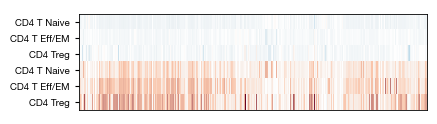

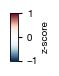

In [15]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(4.5, 1.25))  # Adjust figsize for overall image size

cvals = [-1.0, -0.5, -0.4, -0.33, 0.0, 0.33, 0.4, 0.5, 1.0]
colors = ["#053061", "#b8d8e8", "#dbe9f1", "#ebf1f4", "#FFFFFF", "#f8eee8", "#fbe2d4", "#f9c5ab", "#67001f"]
norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))

cmap = mcolors.LinearSegmentedColormap.from_list("cmap", tuples)
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cax = ax.matshow(subset_df_transformed.iloc[:, 2:], cmap=cmap, norm=norm, aspect='auto', rasterized=True)

row_labels = ['CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg', 'CD4 T Naive', 'CD4 T Eff/EM', 'CD4 Treg']

ax.set_xticks([])
ax.set_yticks(range(len(row_labels)))
ax.set_yticklabels(row_labels)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.6)
    
plt.savefig(output_dir / 'compass_heatmap.svg', dpi=1200, transparent=True)
plt.show()

fig_cbar, ax_cbar = plt.subplots(figsize=(0.1, 0.6125))
cbar = fig_cbar.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
cbar.set_label('z-score', rotation=90, labelpad=2)

plt.savefig(output_dir / 'compass_heatmap-colorbar.svg', transparent=True)
plt.show()

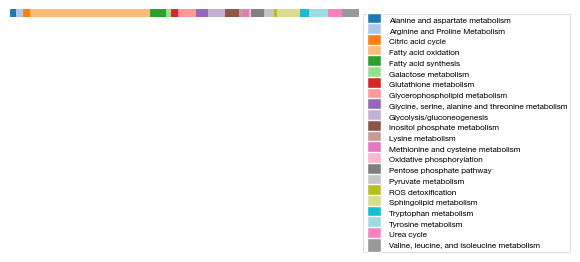

In [16]:
# Define the unique subsystem names (these are the column names from the 4th column onwards)
unique_subsystem_names = list(set(subset_df_transformed.columns[2:]))  # Extract unique names
unique_subsystem_names.sort()  # Sort the names to have a consistent order

tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
additional_colors = [(0.97, 0.51, 0.75, 1), (0.6, 0.6, 0.6, 1)]
all_colors = np.vstack((tab20_colors, additional_colors))

# Map subsystem to color
subsystem_to_color = {subsystem: all_colors[i] for i, subsystem in enumerate(unique_subsystem_names)}

# Create legend
fig, ax = plt.subplots(figsize=(4.5, 0.1))

for i, subsystem in enumerate(subset_df_transformed.columns[2:]):
    color = subsystem_to_color[subsystem]
    ax.add_patch(patches.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(subset_df_transformed.columns[2:]))
ax.set_ylim(0, 1)
ax.axis('off')  # Hide the axis for a cleaner look

legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=subsystem_to_color[subsystem], markersize=10, label=subsystem) for subsystem in unique_subsystem_names]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.savefig(output_dir / 'compass_heatmap-legend.svg', transparent=True)
plt.show()

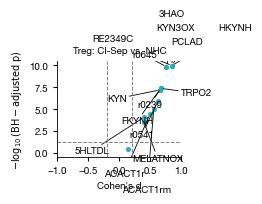

In [17]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for 'Tryptophan metabolism' and prepare as dataframe
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_NHC_CD4_Treg').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform Wilcoxon rank-sum test and calculate Cohen's d for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)

    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Benjamini-Hochberg correction
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(1.6, 1.25))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("Treg: CI-Sep vs. NHC")
plt.xlim(-1, 1.0)
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.ylim(-0.5, 10.5)
plt.yticks(np.arange(0, 10.1, 2.5))

adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_static=(0.3, 0.4),
    force_explode=(0.3, 0.5),
    expand=(1.5, 1.5),
    ensure_inside_axes=False,
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

plt.savefig(output_dir / 'compass_scatter_treg_cisep-vs-nhc.svg', transparent=True)
plt.show()

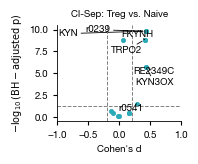

In [18]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for 'Tryptophan metabolism' and prepare as dataframe
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_T_Naive').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform Wilcoxon rank-sum test and calculate Cohen's d for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)

    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Benjamini-Hochberg correction
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(1.6, 1.25))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("CI-Sep: Treg vs. Naive")
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.xlim(-1, 1.0)
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.ylim(-0.5, 10.5)
plt.yticks(np.arange(0, 10.1, 2.5))

adjust_text(
    texts,
    force_text=(0.5, 0.5),
    force_static=(0.5, 0.5),
    force_explode=(0.5, 0.1),
    expand=(1.2, 1.2),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

plt.savefig(output_dir / 'compass_scatter_cisep_treg-vs-naive.svg',transparent=True)
plt.show()

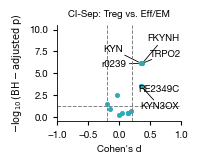

In [19]:
# Function to calculate Cohen's d
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Filter combined_df_meta for 'Tryptophan metabolism' and prepare as dataframe
tryptophan_df = combined_df_meta[combined_df_meta['subsystem'] == "Tryptophan metabolism"]

group_1_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_T_EffEM').columns
group_2_columns = tryptophan_df.filter(regex='^cluster_\d+_CI-Sep_CD4_Treg').columns

results_df = pd.DataFrame(columns=['Reaction', 'Statistic', 'P_Value', 'Cohens_d'])

# Perform Wilcoxon rank-sum test and calculate Cohen's d for each reaction within Tryptophan metabolism
for reaction in tryptophan_df['Reaction'].unique():
    group1 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_1_columns].values.flatten()
    group2 = tryptophan_df.loc[tryptophan_df['Reaction'] == reaction, group_2_columns].values.flatten()
    
    stat, p_value = ranksums(group2, group1)
    d = cohens_d(group2, group1)

    results_df = results_df.append({'Reaction': reaction, 'Statistic': stat, 'P_Value': p_value, 'Cohens_d': d}, ignore_index=True)

# Benjamini-Hochberg correction
p_vals = results_df['P_Value'].values
_, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
results_df['p_value_adj'] = pvals_corrected

# Plot Cohen's d vs. adjusted p-value
plt.figure(figsize=(1.6, 1.25))
plt.scatter(results_df['Cohens_d'], -np.log10(results_df['p_value_adj']), color='#2DABB9', alpha=1)

plt.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.7)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=0.7)

texts = []
for i, row in results_df.iterrows():
    if row['p_value_adj'] < 0.05 and (row['Cohens_d'] > 0.2 or row['Cohens_d'] < -0.2):
        texts.append(plt.text(row['Cohens_d'], -np.log10(row['p_value_adj']), row['Reaction'], ha='left'))

plt.xlabel("Cohen's d")
plt.ylabel(r"$-\log_{10}(\mathrm{BH-adjusted\ p})$")
plt.title("CI-Sep: Treg vs. Eff/EM")
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.xlim(-1, 1.0)
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.ylim(-0.5, 10.5)
plt.yticks(np.arange(0, 10.1, 2.5))

adjust_text(
    texts,
    force_text=(0.5, 0.5),
    force_static=(0.5, 0.4),
    force_explode=(0.7, 0.1),
    expand=(1.2, 1.2),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.6)
)

plt.savefig(output_dir / 'compass_scatter_cisep_treg-vs-effem.svg',transparent=True)
plt.show()

In [20]:
# Import anndata object
adata_path = (REPO_ROOT / "GSE290679_10069-MS_allsamples_processed_labeled_filtered.h5ad").resolve()

if not adata_path.exists():
    raise FileNotFoundError(
        f"AnnData file not found at:\n{adata_path}\n\n"
        "Download the file from GEO (GSE290679) and place it in the repository root."
    )

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

In [21]:
# Subset to CD4 T cell types of interest
subset_celltypes = ["CD4 T Naive", "CD4 T Eff/EM", "CD4 Treg"]

adata_subset = adata[adata.obs["celltype_fine"].isin(subset_celltypes)].copy()

adata_subset.var_names = adata_subset.var_names.str.upper()

# Create combined group label and set plotting order
adata_subset.obs["Group_CellType"] = (
    adata_subset.obs["Group"].astype(str) + " " + adata_subset.obs["celltype_fine"].astype(str)
)

order = [
    "NHC CD4 T Naive",
    "CI-Sep CD4 T Naive",
    "NHC CD4 T Eff/EM",
    "CI-Sep CD4 T Eff/EM",
    "NHC CD4 Treg",
    "CI-Sep CD4 Treg",
]

adata_subset.obs["Group_CellType"] = adata_subset.obs["Group_CellType"].astype(
    pd.CategoricalDtype(categories=order, ordered=True)
)

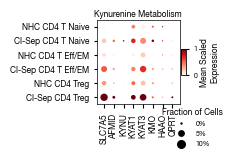

In [22]:
# Define plotting order
celltype_order = [
    'NHC CD4 T Naive', 'CI-Sep CD4 T Naive',
    'NHC CD4 T Eff/EM', 'CI-Sep CD4 T Eff/EM',
    'NHC CD4 Treg', 'CI-Sep CD4 Treg'
]

# Kynurenine metabolism gene list
kynurenine_genes = ["SLC7A5", "AFMID", "KYNU", "KYAT1", "KYAT3", "KMO", "HAAO", "QPRT"]

subpanel_genes = {"Kynurenine Metabolism": kynurenine_genes}

# Prepare gene expression data (mean + %expressing)
adata_exp = adata_subset.raw.to_adata()
adata_sub = adata_exp[:, kynurenine_genes]
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.tocsr()

cell_types = adata_sub.obs['Group_CellType'].values
plot_data = []
for ct in celltype_order:
    idx = np.where(cell_types == ct)[0]
    if len(idx) == 0:
        continue
    X_ct = X[idx]
    mean = np.asarray(X_ct.mean(axis=0)).ravel() if scipy.sparse.issparse(X_ct) else X_ct.mean(axis=0)
    pct  = np.asarray((X_ct > 0).mean(axis=0)).ravel()*100 if scipy.sparse.issparse(X_ct) else (X_ct > 0).mean(axis=0)*100
    for gene_idx, gene in enumerate(kynurenine_genes):
        plot_data.append((ct, gene, mean[gene_idx], pct[gene_idx]))

# Create dataframe for plotting
plot_df = pd.DataFrame(plot_data, columns=["celltype", "genes", "mean_expression", "percent_cells"])
plot_df["celltype"] = pd.Categorical(plot_df["celltype"], categories=celltype_order, ordered=True)
plot_df["genes"] = pd.Categorical(plot_df["genes"], categories=kynurenine_genes, ordered=True)
plot_df["percent_cells_clipped"] = np.clip(plot_df["percent_cells"], 0, 10)
plot_df["mean_expression_scaled"] = (
    plot_df.groupby("genes")["mean_expression"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
)

# Create dotplot
panel_widths = [len(kynurenine_genes)]
total_width = 1.15
height = 1.1

fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(total_width, height),
    gridspec_kw={"width_ratios": panel_widths},
    sharey=True
)

axes = [axes]

for i, (ax, (panel_name, genes_subset)) in enumerate(zip(axes, subpanel_genes.items())):
    sub_df = plot_df[plot_df["genes"].isin(genes_subset)].copy()
    sub_df["genes"] = pd.Categorical(sub_df["genes"], categories=genes_subset, ordered=True)
    sub_df["celltype"] = pd.Categorical(sub_df["celltype"], categories=celltype_order, ordered=True)

    sns.scatterplot(
        data=sub_df, x="genes", y="celltype",
        size="percent_cells_clipped",
        size_norm=(0, 10),
        hue="mean_expression_scaled",
        palette="Reds",
        sizes=(0.5, 30),
        legend=False,
        ax=ax
    )

    ax.set_xticks(np.arange(len(genes_subset)))
    ax.set_xticklabels(genes_subset, fontsize=6, rotation=90)
    ax.set_xlim(-0.75, len(genes_subset) - 0.25)
    ax.set_ylim(-0.5, len(celltype_order) - 0.5)
    ax.invert_yaxis()
    ax.set_xlabel('')
    ax.set_title(panel_name, fontsize=6, pad=2)
    ax.set_ylabel('')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

axes[0].set_yticks(np.arange(len(celltype_order)))
axes[0].set_yticklabels(celltype_order, fontsize=6)
axes[0].tick_params(axis='y', length=2)

plt.subplots_adjust(wspace=0.05)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap='Reds')
sm.set_array([])

cbar = fig.colorbar(
    sm, ax=axes, orientation='vertical',
    fraction=0.05, pad=0.02, aspect=6
)
cbar.set_label("Mean Scaled\nExpression", fontsize=6, labelpad=2)
cbar.ax.tick_params(labelsize=5, length=2)

size_min, size_max = 0.5, 30
percent_values = [0, 5, 10]
size_values = [size_min + (p/10)*(size_max-size_min) for p in percent_values]

dot_handles = [
    Line2D([], [], marker='o', color='black', linestyle='None',
           markersize=np.sqrt(s), label=f"{p}%", alpha=1)
    for p, s in zip(percent_values, size_values)
]

fig.legend(
    handles=dot_handles, title="Fraction of Cells",
    loc='lower right', fontsize=5, title_fontsize=6,
    frameon=False, handletextpad=1, labelspacing=0.6, borderpad=0.5
)

plt.savefig(output_dir / "CD4_kynurenine_dotplot.svg")
plt.show()

In [23]:
# Subset to CD4 Treg
adata_filtered = adata[
    (adata.obs["Group"].isin(["NHC", "CI-Sep"])) &
    (adata.obs["celltype_fine"].isin(["CD4 Treg"]))
].copy()

# Consensus human AHR gene set
gene_set_name = "Sadik_2020_Pan-Tissue-AHR-Signature"
genes = [
    "ABCC4", "ABCG2", "ACTA2", "ADM", "AHR", "AHRR", "ALDH3A1", "AMIGO2", "AQP3", "AREG",
    "ARG2", "ATP12A", "ATP5IF1", "ATP5ME", "ATP6AP2", "BCL11B", "BCL2", "BCL6", "BLNK",
    "BRCA1", "C21orf33", "CARD11", "CAV1", "CCL5", "CCND1", "CD36", "CD3E", "CD8A",
    "CDK4", "CDKN1A", "CFTR", "CRH", "CXCL2", "CYBB", "CYP19A1", "CYP1A1", "CYP1A2",
    "CYP1B1", "CYP2B6", "CYP2E1", "CYP3A4", "DKK3", "DLX3", "DUOX2", "EBF1", "EDN1",
    "EGFR", "EGR1", "EPGN", "EREG", "ESR1", "F3", "FAS", "FAT1", "FBXO32", "FGFR2",
    "FIG4", "FLG", "FOS", "FOXA1", "FOXQ1", "FPR2", "GATA3", "GFI1", "GHR", "GNA13",
    "GSTA2", "GSTM1", "HES1", "HIF1A", "HLA-DRB4", "HMOX1", "HSD17B4", "HSPB2",
    "ID1", "ID2", "IFNG", "IGF2", "IGFBP1", "IKZF3", "IL1B", "IL1R2", "IL2", "IL6",
    "INSIG1", "IRF8", "JAG1", "JUP", "KDM1A", "KIAA1549", "KIT", "KMO", "LEPR",
    "LHCGR", "LIFR", "LPL", "LTBP1", "LYN", "MID1", "MMP1", "MSI2", "MYC", "NANOG",
    "NCOA2", "NCOR2", "NDRG1", "NEDD9", "NFE2L2", "NOS1", "NOS3", "NPTX1", "NQO1",
    "NR1H3", "NR1H4", "NR3C1", "NRIP1", "NSDHL", "OVOL1", "PAX5", "PCK1", "PCK2",
    "PDE2A", "PDS5B", "PER1", "PHGDH", "PIWIL1", "PIWIL2", "PLA2G4A", "PNPLA7",
    "POLK", "PPARGC1A", "PRDM1", "PTGS2", "RARA", "REL", "RFC3", "RSPO3", "SCARB1",
    "SCIN", "SERPINB2", "SERPINE1", "SESN2", "SH3KBP1", "SLC10A1", "SLC3A2", "SLC7A5",
    "SMAD3", "SMAD7", "SOCS2", "SORL1", "SOS1", "SPRR2D", "STC2", "TFF1", "TGFBI",
    "TGM1", "TH", "THBS1", "TIPARP", "TJP1", "TNFSF9", "TXNRD1", "UGT1A6", "VAV3",
    "XDH", "ZIC3"
]

# Run AUCell and extract results to dataframe
net = pd.DataFrame({"source": gene_set_name, "target": genes})

dc.run_aucell(
    mat=adata_filtered, net=net, source="source", target="target",
    n_up=None, min_n=5, seed=28, use_raw=True, verbose=True
)

aucell_scores = adata_filtered.obsm["aucell_estimate"][gene_set_name]
groups = adata_filtered.obs["Group"]

df_aucell = pd.DataFrame({
    "AUCell Scores": aucell_scores,
    "Group": groups,
    "CellType": "CD4 Treg"
}).reset_index(drop=True)

df_aucell

14286 features of mat are empty, they will be removed.
Running aucell on mat with 7835 samples and 22315 targets for 1 sources.


100%|███████████████████████████████████████| 7835/7835 [01:34<00:00, 83.30it/s]


,AUCell Scores,Group,CellType
0,0.044197,CI-Sep,CD4 Treg
1,0.040115,CI-Sep,CD4 Treg
2,0.051247,CI-Sep,CD4 Treg
3,0.018972,CI-Sep,CD4 Treg
4,0.049195,CI-Sep,CD4 Treg
...,...,...,...
7830,0.050687,CI-Sep,CD4 Treg
7831,0.030673,CI-Sep,CD4 Treg
7832,0.005124,CI-Sep,CD4 Treg
7833,0.062427,CI-Sep,CD4 Treg


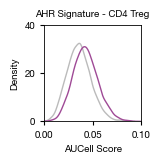

In [24]:
# Setup
colors = {
    "NHC": "#BBBBBB",
    "CI-Sep": "#9F4A96"
}

plt.figure(figsize=(1.25, 1.25))

cell_type = "CD4 Treg"
cell_type_df = df_aucell[df_aucell["CellType"] == cell_type]

# Plot
for group in colors:
    group_scores = cell_type_df.loc[cell_type_df["Group"] == group, "AUCell Scores"]
    sns.kdeplot(group_scores, color=colors[group], lw=1, fill=False)

plt.xlim(0, 0.1)
plt.xticks([0, 0.05, 0.1])
plt.ylim(0, 40)
plt.yticks([0, 20, 40])
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["right"].set_visible(True)

plt.xlabel("AUCell Score")
plt.ylabel("Density")
plt.title("AHR Signature - CD4 Treg")

plt.savefig(output_dir / "ahr_cd4_treg.svg", format="svg")
plt.show()